# Preamble

In [1]:
from utils.utils import *
from utils.network import *
from utils.visualization import *

import numpy as np
import re
import subprocess
import networkx as nx
import random
from multiprocessing import Pool
from sklearn.metrics.cluster import adjusted_mutual_info_score

In [2]:
standarize_plot_parameters()

### Utility functions

In [3]:
def multilayer_network_with_L_samples(G_arr, L, shuf=False):
    """Take T independent networks and sample L subgraphs from each.
    
    Input
    -----
        G_arr : list of nx.Graph objects
        L : number (int) of subgraphs to create for each element in G_arr
        shuf : bool. whether or not to shuffle order of subgraphs
        
    Output
    ------
        out : str. pajek-formatted multilayer network
    """
    def _sample_from_graph(G, p):
        G_sample = nx.Graph()
        G_sample.add_nodes_from(G.nodes())
        G_sample.add_edges_from(random.sample(G.edges(), int(p*len(G.edges()))))
        return G_sample
    
    G_arr_sampled = []
    for G in G_arr:
        for _ in range(L):
            G_arr_sampled.append(_sample_from_graph(G, 1.0/L))
        
    if shuf:
        G_arr_sampled, order = shuffle_order(G_arr_sampled)
        return graph_list_to_pajek(G_arr_sampled), order

    return graph_list_to_pajek(G_arr_sampled)
    
def multiplex_AMI(layer_commu, L, partitions):
    """Compute multiplex AMI of 
    """
    multilayer_partition_true = dict()
    multilayer_partition_pred = dict()
    for i in range(len(partitions)):
        for l in range(L):
            layer = i*L + l
            multilayer_partition_true.update(
                dict(
                    (str(layer) + str(n), int(str(i) + str(c)))
                    for n, c in partitions[i].items()
                )
            )
            multilayer_partition_pred.update(
                dict(
                    (str(layer) + str(n), c)
                    for n, c in invert_partition(layer_commu[layer]).items()
                )
            )
    return NMI_score(multilayer_partition_true, multilayer_partition_pred)

def method_args(method, r):
    return {
        'FC': ['--multiplex-relax-rate', str(r)],
        'NC': ['--multiplex-relax-rate', '0', '--multiplex-relax-limit', '1'],
        'NFC': ['--multiplex-js-relax-rate', str(r)],
        'AC': ['--multiplex-relax-rate', str(r), '--multiplex-relax-limit', '1']
    }[method]


def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

# Analysis

## Fig 4.d-e

### Experiment

In [51]:
def worker(args):
    """Worker function for running Infomap. Enables parallelization."""
    if len(args) == 2:
        args, order = args
        _, _layer_commu, _, _ = Infomap(*args)
        _layer_commu = reorder_shuffled_layer_commu(_layer_commu, order)
    else:
        _, _layer_commu, _, _ = Infomap(*args)
    return _layer_commu, args[-1][3:]
    
def AMI_vs_L(G_arr, partitions, L_max, parallel, n_procs):
    """Compute the multiplex AMI of NFC, FC, AC and NC for a range of L values (sparsity).
    
    Input
    -----
        G_arr : list of nx.Graph
            Length of G_arr is T, and each nx.Graph corresponds to an independent mode.
        partitions : list of dicts
            Each dict gives the partition of a mode.
        L_max : int
            Maximum value of L to test. (independent variable max)
        parallel : bool (for debugging)
        
    Output
    ------
        out : tuple
            lists: `AMI_NFC`, `AMI_FC`, `AMI_AC`, `AMI_ACshuf`, `AMI_NC`. Each list
            contains multiplex AMI for the range of tested L values.
    """
    
    AMI_NFC, AMI_FC, AMI_AC, AMI_ACshuf, AMI_NC = [], [], [], [], []
    L_arr = range(1, L_max+1)
    
    data = []
    
    for L in L_arr:
        pajek_synth = multilayer_network_with_L_samples(G_arr, L)
        pajek_synth_shuf, order = multilayer_network_with_L_samples(G_arr, L, shuf=True)
        
        args = [
            pajek_synth,
            '-i',
            'multiplex',
            '--multiplex-js-relax-rate', '0.25',
            '--overlapping',
            '--expanded',
            '--clu',
            '--two-level',
            '-z',
            'pidNFC_L%d' % L
        ]
        
        data.append(args)

        args = [
            pajek_synth,
            '-i',
            'multiplex',
            '--multiplex-relax-rate', '0.25',
            '--overlapping',
            '--expanded',
            '--clu',
            '--two-level',
            '-z',
            'pidFC_L%d' % L
        ]
        
        data.append(args)

        args = [
            pajek_synth,
            '-i',
            'multiplex',
            '--multiplex-relax-rate', '0.25',
            '--multiplex-relax-limit', '1'
            '--overlapping',
            '--expanded',
            '--clu',
            '--two-level',
            '-z',
            'pidAC_L%d' % L
        ]
        
        data.append(args)

        args = [(
            pajek_synth_shuf,
            '-i',
            'multiplex',
            '--multiplex-relax-rate', '0.25',
            '--multiplex-relax-limit', '1'
            '--overlapping',
            '--expanded',
            '--clu',
            '--two-level',
            '-z',
            'pidACshuf_L%d' % L
        ), order]
        
        data.append(args)

        args = [
            pajek_synth,
            '-i',
            'multiplex',
            '--multiplex-relax-rate', '0.0',
            '--multiplex-relax-limit', '1',
            '--overlapping',
            '--expanded',
            '--clu',
            '--two-level',
            '-z',
            'pidNC_L%d' % L
        ]
        
        data.append(args)
    
    if parallel:
        p = Pool(n_procs)
        processes = p.map(worker, data)
    else:
        processes = map(worker, data)
    
    for output in processes:
        layer_commu, pid = output
        algo = pid.split("_")[0]
        L = int(pid.split("L")[1])
        locals()['AMI_%s' % algo].append(multiplex_AMI(layer_commu, L, partitions))
    
    if parallel:
        p.close()
    
    return AMI_NFC, AMI_FC, AMI_AC, AMI_ACshuf, AMI_NC

def run_simulation(T, n_iter, L_max, parallel, LFR_params, *args):
    
    if args == ():
        NFC, FC, AC, ACshuf, NC = [], [], [], [], []
    else:
        NFC, FC, AC, ACshuf, NC = args
        
    for i in range(n_iter):
        G_arr, partitions = map(
            list,
            zip(*[LFR_benchmark_graph(**LFR_params) for _ in range(T)])
        )
        while True:
            try:
                AMI_NFC, AMI_FC, AMI_AC, AMI_ACshuf, AMI_NC = AMI_vs_L(G_arr, partitions, L_max, parallel, 8)
                break
            except KeyError:
                print "KeyError",
                
        NFC.append(AMI_NFC)
        FC.append(AMI_FC)
        AC.append(AMI_AC)
        ACshuf.append(AMI_ACshuf)
        NC.append(AMI_NC)
        print i,
        
    return NFC, FC, AC, ACshuf, NC

### Parameters

In [72]:
# The parameters used to generate modes
L_max = 24
LFR_params = dict(N=128, k=16, maxk=32, mu=0.05, t1=2.5, t2=1.5)

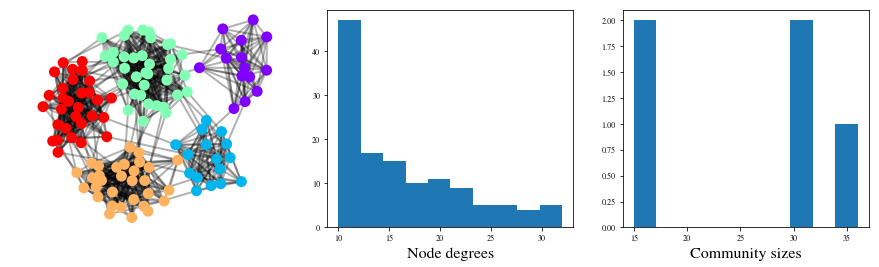

In [73]:
# An example of what a mode looks like
G_example, partition_example = LFR_benchmark_graph(**LFR_params)

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
draw(G_example, partition=partition_example)
plt.subplot(1, 3, 2)
plt.hist([d for n, d in G_example.degree()])
plt.xlabel("Node degrees", fontsize=16)
plt.subplot(1, 3, 3)
plt.hist([len(nodes) for n, nodes in invert_partition(partition_example).items()])
plt.xlabel("Community sizes", fontsize=16)
plt.show()

### Run

In [53]:
NFC_T1, FC_T1, AC_T1, ACshuf_T1, NC_T1 = run_simulation(1, 40, L_max, True, LFR_params)
NFC_T3, FC_T3, AC_T3, ACshuf_T3, NC_T3 = run_simulation(3, 40, L_max, True, LFR_params)
NFC_T10, FC_T10, AC_T10, ACshuf_T10, NC_T10 = run_simulation(10, 20, L_max, True, LFR_params=LFR_params)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19


### Visualize

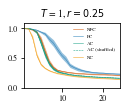

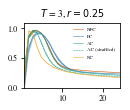

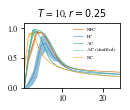

In [59]:
labelmap = {1: "d", 3: 'e', 10: 'T10'}
for T in [1, 3, 10]:

    X = [range(1, L_max+1)]
    
    plt.figure(figsize=(3.42/2.0, 1.2))
    plt.title("$T$ = %d, $r = 0.25$" % T)
    confidence_intervals(X, globals()["NFC_T%d" % T], c="#d35400", label="NFC", lw=0.5)
    confidence_intervals(X, globals()["FC_T%d" % T], "#2980b9", label="FC", lw=0.5)
    confidence_intervals(X, globals()["AC_T%d" % T], c="#16a085", label="AC", lw=0.5)
    confidence_intervals(X, globals()["ACshuf_T%d" % T], c="#16a085", label="AC (shuffled)", lw=0.5, ls="--")
    confidence_intervals(X, globals()["NC_T%d" % T], c="#f39c12", label="NC", lw=0.5)

    plt.xlim(1, L_max)
    plt.ylim(0, 1.1)

    plt.legend(loc="upper right", fontsize=5, frameon=False)
    plt.savefig("figures/Fig4%s.pdf" % labelmap[T])
    plt.show()
    

## Fig b

### Experiment

In [61]:
def AMI_vs_r(G_arr, partitions, L, r_values, method, shuffle=False):
    """Compute the multiplex AMI of NFC, FC, AC (and NC) for a range of relax rates.
    
    Input
    -----
        G_arr : list of nx.Graph
            Length of G_arr is T, and each nx.Graph corresponds to an independent mode.
        partitions : list of dicts
            Each dict gives the partition of a mode.
        L : int
            The sparsity level at which to measure AMI
        r_values : list
            Relax rates to test AMI in (independent variable)
        parallel : bool (for debugging)
        
    Output
    ------
        out : tuple
            lists: `AMI_NFC`, `AMI_FC`, `AMI_AC`, `AMI_ACshuf`, `AMI_NC`. Each list
            contains multiplex AMI for the range of tested L values.
    """
    
    AMI_NFC = []
    for relax_rate in r_values:
        pajek_synth = multilayer_network_with_L_samples(G_arr, L)
        
        if shuffle:
            pajek_synth, order = multilayer_network_with_L_samples(G_arr, L, shuf=True)  # FOR SHUFFLED

        args = [
            pajek_synth,
            '-i',
            'multiplex'
        ] + method_args(method, relax_rate) + [
            '--overlapping',
            '--expanded',
            '--clu',
            '--two-level',
            '-z',
            'pid%s_%d' % (method, random.randint(0, 100000000))
        ]
        
        _, layer_commu, _, _ = Infomap(*args)
        if shuffle:
            layer_commu = reorder_shuffled_layer_commu(layer_commu, order)  # FOR SHUFFLED
        
        AMI_NFC.append(multiplex_AMI(layer_commu, L, partitions))
    
    return AMI_NFC

def worker((mu, L, r_values, method, shuffle, G_arr_and_partitions, _iter)):
    G_arr, partitions = map(list, zip(*G_arr_and_partitions))
    return AMI_vs_r(G_arr, partitions, L, r_values, method, shuffle)

def run_simulation(T, L, LFR_params, r_values, method, shuffle, parallel, n_procs, n_iter, *args):
    
    print "Running simulation with T = %d, over %d iterations" % (T, n_iter)
    
    if args == ():
        out = []
    else:
        out = args[0]
    
    G_arr_and_partitions = [LFR_benchmark_graph(**LFR_params) for _ in range(T)]
    
    data = [
        [0.05, L, r_values, method, shuffle, G_arr_and_partitions, _iter]
        for _iter in range(n_iter)
    ]
    
    if parallel:
        p = Pool(n_procs)
        out.extend(p.map(worker, data))
        p.close()
    else:
        out.extend(map(worker, data))
        
    return out

### Parameters

In [62]:
r_values = [0.0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.999]
LFR_params = dict(N=128, k=16, maxk=32, mu=0.05, t1=2.5, t2=1.5)
T = 3
L = 5

### Run

In [63]:
NFCT3L5 = run_simulation(T, L, LFR_params, r_values, "NFC", False, True, 8, 40)
ACT3L5 = run_simulation(T, L, LFR_params, r_values, "AC", False, True, 8, 40)
ACshufT3L5 = run_simulation(T, L, LFR_params, r_values, "AC", True, True, 8, 40)
FCT3L5 = run_simulation(T, L, LFR_params, r_values, "FC", False, True, 8, 40)
NCT3L5 = run_simulation(T, L, LFR_params, r_values, "NC", False, True, 8, 40)

Running simulation with T = 3, over 40 iterations
Running simulation with T = 3, over 40 iterations
Running simulation with T = 3, over 40 iterations
Running simulation with T = 3, over 40 iterations
Running simulation with T = 3, over 40 iterations


### Visualize

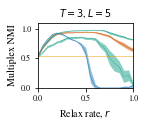

In [65]:
plt.figure(None, figsize=(3.42/2.0, 1.2), frameon=False)
plt.plot(r_values, [np.mean(NCT3L5)]*len(r_values), c="#f39c12", lw=0.5)
confidence_intervals([r_values], NFCT3L5, c="#d35400", label=T, lw=0.5)
confidence_intervals([r_values], ACT3L5, c="#16a085", label=T, lw=0.5)
confidence_intervals([r_values], ACshufT3L5, c="#16a085", label=T, lw=0.5, ls="--")
confidence_intervals([r_values], FCT3L5, c="#2980b9", label=T, lw=0.5)

plt.xlim(0, 1.0)
plt.ylim(0, 1.1)

plt.title("$T=3$, $L=5$")
plt.xlabel("Relax rate, $r$")
plt.ylabel("Multiplex NMI")

plt.savefig("figures/Fig4b.pdf")
plt.show()

## Fig. 4c

### Experiment

In [4]:
def worker(args):
    """Worker function for running Infomap. Enables parallelization."""
    if len(args) == 4: # Shuffled
        args, L, partitions, order = args
        _, _layer_commu, _, _ = Infomap(*args)
        _layer_commu = reorder_shuffled_layer_commu(_layer_commu, order)
    else:
        args, L, partitions = args
        _, _layer_commu, _, _ = Infomap(*args)
    return multiplex_AMI(_layer_commu, L, partitions), args[-1][3:]
    
def AMI_vs_T(T_arr, L, parallel, n_procs):
    """Compute the multiplex AMI of NFC, FC, AC and NC for a range of L values (sparsity).
    
    Input
    -----
        T_arr : list of ints
            T values to test (independent variable)
        L : int
            Number of samples to use
        parallel : bool (for debugging)
        n_procs : int (number of processes if parallel)
        
    Output
    ------
        out : tuple
            lists: `AMI_NFC`, `AMI_FC`, `AMI_AC`, `AMI_ACshuf`, `AMI_NC`. Each list
            contains multiplex AMI for the range of tested T values.
    """
    
    AMI_NFC, AMI_FC, AMI_AC, AMI_ACshuf, AMI_NC = [], [], [], [], []
    
    print "\t... Preparing input data"
    
    data = []
    for T in log_progress(T_arr, every=1):
        
        G_arr, partitions = map(
            list,
            zip(*[LFR_benchmark_graph(**LFR_params) for _ in range(T)])
        )
        
        pajek_synth = multilayer_network_with_L_samples(G_arr, L)
        pajek_synth_shuf, order = multilayer_network_with_L_samples(G_arr, L, shuf=True)
        
        for method in ['NFC', 'FC', 'AC', 'NC']:
            data.append([[
                pajek_synth,
                '-i',
                'multiplex'
            ] + method_args(method, 0.25) + [
                '--overlapping',
                '--expanded',
                '--clu',
                '--two-level',
                '-z',
                'pid%s_T%d' % (method, T)
            ], L, partitions])

        data.append([[
            pajek_synth_shuf,
            '-i',
            'multiplex',
            '--multiplex-relax-rate', '0.25',
            '--multiplex-relax-limit', '1'
            '--overlapping',
            '--expanded',
            '--clu',
            '--two-level',
            '-z',
            'pidACshuf_T%d' % T
        ], L, partitions, order])
    
    if parallel:
        print "\t... Pooling %d processes" % len(data)
        p = Pool(n_procs)
        processes = p.map(worker, data)
        p.close()
    else:
        print "\t... Processing serially"
        processes = map(worker, data)
    
    print "\t--> DONE! Extracting data and returning output"
    for output in processes:
        measured_AMI, pid = output
        algo = pid.split("_")[0]
        T = int(pid.split("T")[1])
        locals()['AMI_%s' % algo].append(measured_AMI)
    
    return AMI_NFC, AMI_FC, AMI_AC, AMI_ACshuf, AMI_NC

def run_simulation(T_arr, L, LFR_params, parallel, n_procs, n_iter, *args):
    
    if args == ():
        NFC, FC, AC, ACshuf, NC = [], [], [], [], []
    else:
        NFC, FC, AC, ACshuf, NC = args
        
    for i in range(n_iter):

        while True:
            try:
                AMI_NFC, AMI_FC, AMI_AC, AMI_ACshuf, AMI_NC = AMI_vs_T(T_arr, L, parallel, 8)
                break
            except KeyError:
                print "KeyError",
                
        NFC.append(AMI_NFC)
        FC.append(AMI_FC)
        AC.append(AMI_AC)
        ACshuf.append(AMI_ACshuf)
        NC.append(AMI_NC)
        print i,
        
    return NFC, FC, AC, ACshuf, NC

### Parameters

In [5]:
L = 5
n_iter = 1
T_arr = range(1, 10) + range(10, 20, 2) + range(20, 30, 5) + range(30, 60, 10)
LFR_params = dict(N=128, k=16, maxk=32, mu=0.05, t1=2.5, t2=1.5)

### Run

In [69]:
T_arr_out, NFCL5, FCL5, ACL5, ACshufL5, NCL5 = run_simulation(T_arr, L, LFR_params, True, 8, 1)  # 1 iteration about takes 8m 31sNFCL5, FCL5, ACL5, ACshufL5, NCL5 = run_simulation(T_arr, L, LFR_params, True, 8, 40)  # 1 iteration about takes 8m 31s

Iteration 1
	... Preparing input data
	... Pooling 19 processes
	    --- Running Infomap (T=14)
	    --- Running Infomap (T=16)
	    --- Running Infomap (T=18)
	    --- Running Infomap (T=20)
	    --- Running Infomap (T=25)
	    --- Running Infomap (T=30)
	    --- Running Infomap (T=40)
	    --- Running Infomap (T=50)
	    --> Infomap done! (T=14)
	    --- Running Infomap (T=12)
	    --> Infomap done! (T=16)
	    --- Running Infomap (T=10)
	    --> Infomap done! (T=12)
	    --- Running Infomap (T=9)
	    --> Infomap done! (T=18)
	    --- Running Infomap (T=8)
	    --> Infomap done! (T=10)
	    --- Running Infomap (T=7)
	    --> Infomap done! (T=9)
	    --- Running Infomap (T=6)
	    --> Infomap done! (T=8)
	    --> Infomap done! (T=7)
	    --- Running Infomap (T=4)
	    --- Running Infomap (T=5)
	    --> Infomap done! (T=20)
	    --> Infomap done! (T=4)
	    --- Running Infomap (T=3)
	    --- Running Infomap (T=2)
	    --> Infomap done! (T=2)
	    --- Running Infomap (T=1)
	    --> Inf

### Visualize

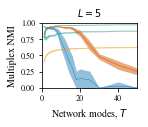

In [70]:
plt.figure(None, figsize=(3.42/2.0, 1.2), frameon=False)

confidence_intervals([T_arr], NFCL5, c="#d35400", label="NFC", lw=0.5)
confidence_intervals([T_arr], FCL5, c="#2980b9", label="FC", lw=0.5)
confidence_intervals([T_arr], ACL5, c="#16a085", label="AC", lw=0.5)
confidence_intervals([T_arr], ACshufL5, c="#16a085", label="AC (shuffled)", lw=0.5, ls="--")
confidence_intervals([T_arr], NCL5, c="#f39c12", label="NC", lw=0.5)

plt.xlim(0, 50)
plt.ylim(0.0, 1)

#plt.yticks([0.7, 0.8, 0.9, 1.0]) 

plt.title("$L=5$")
plt.xlabel("Network modes, $T$")
plt.ylabel("Multiplex NMI")

#plt.savefig("figures/Fig4c.pdf")
plt.show()